# Unsupervised Learning applied to Customer Lifetime Value (CLV)

![](https://wilsonprintingusa.com/wp-content/uploads/2015/02/Customer-Lifetime-Value-Wilson-Printing.jpg)

# Prepare Workspace

In [1]:
# Upload libraries
from numpy.random import seed
seed(1)
import tensorflow.keras
tensorflow.random.set_seed(2)

# to handle datasets
import numpy as np
import pandas as pd
import datetime

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# for statistics
import statistics as st 
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to split data set 
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# to build models
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# dimensionality reductiion
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from keras.layers import Input,Dense
from keras.models import Model

# clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# to evaluate models
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('AutoInsurance.csv')

# Data set Overview

In [3]:
# Dimensions of data set
print(df.shape)

(9134, 24)


In [4]:
# List types for each attribute
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [5]:
# Take a peek at the first rows of the data
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,3/2/2011,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


# Data Cleaning & Handling Variables Activity

In [6]:
# Change format Date
df_1 = df.copy()
df_1['Effective_Date'] = pd.to_datetime(df_1['Effective To Date'])

### Handling Missing Values

In [7]:
# Check missing values both to numeric features and categorical features 
missing = df_1.isnull().sum()/df_1.shape[0]*100
missing

Customer                         0.0
State                            0.0
Customer Lifetime Value          0.0
Response                         0.0
Coverage                         0.0
Education                        0.0
Effective To Date                0.0
EmploymentStatus                 0.0
Gender                           0.0
Income                           0.0
Location Code                    0.0
Marital Status                   0.0
Monthly Premium Auto             0.0
Months Since Last Claim          0.0
Months Since Policy Inception    0.0
Number of Open Complaints        0.0
Number of Policies               0.0
Policy Type                      0.0
Policy                           0.0
Renew Offer Type                 0.0
Sales Channel                    0.0
Total Claim Amount               0.0
Vehicle Class                    0.0
Vehicle Size                     0.0
Effective_Date                   0.0
dtype: float64

In [8]:
# Min Value Effective to Date Policy
df_1['Effective_Date'].min()

Timestamp('2011-01-01 00:00:00')

In [9]:
# Max Value Effective to Date Policy
df_1['Effective_Date'].max()

Timestamp('2011-12-02 00:00:00')

In [10]:
# End of Year (eoy) of the current Effective to Date
df_1['eoy_Effective_Date'] = pd.to_datetime('2011-12-31')

In [11]:
# Days missing to the end of the current year from effective to date
df_1['eoy_missing_days'] = (df_1['eoy_Effective_Date'] - df_1['Effective_Date']).dt.days

In [12]:
# check duplicates
df_1_duplicates = df_1[df_1.duplicated(['Customer'])]

In [13]:
df_1_duplicates

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Effective_Date,eoy_Effective_Date,eoy_missing_days


In [14]:
df_1 = df_1.drop(['Customer','Effective To Date','eoy_Effective_Date'], axis=1)

In [15]:
# Rename some features for a practical use
df_new = df_1.copy()
df_new = df_new.rename(columns={"Customer Lifetime Value":"Customer_Lifetime_Value","Location Code":"Location_Code","Marital Status":"Marital_Status","Monthly Premium Auto":"Monthly_Premium_Auto","Months Since Last Claim":"Months_Since_Last_Claim",
                           "Months Since Policy Inception":"Months_Since_Policy_Inception","Number of Open Complaints":"Number_of_Open_Complaints","Number of Policies":"Number_of_Policies",
                           "Policy Type":"Policy_Type","Renew Offer Type":"Renew_Offer_Type","Sales Channel":"Sales_Channel","Total Claim Amount":"Total_Claim_Amount",
                           "Vehicle Class":"Vehicle_Class","Vehicle Size":"Vehicle_Size"})

# Summary Statistics

In [16]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in df_new.columns if df_new[var].dtype=='object']
df_new[obj_cols].describe().T

,count,unique,top,freq
State,9134,5,California,3150
Response,9134,2,No,7826
Coverage,9134,3,Basic,5568
Education,9134,5,Bachelor,2748
EmploymentStatus,9134,5,Employed,5698
Gender,9134,2,F,4658
Location_Code,9134,3,Suburban,5779
Marital_Status,9134,3,Married,5298
Policy_Type,9134,3,Personal Auto,6788
Policy,9134,9,Personal L3,3426


In [17]:
# Summarize attribute distributions for data type of variables
no_obj_cols = [var for var in df_new.columns if df_new[var].dtype!='object']
df_new[no_obj_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Lifetime_Value,9134.0,8004.940475,6870.967608,1898.007675,3994.251794,5780.182197,8962.167041,83325.381190
Income,9134.0,37657.380009,30379.904734,0.000000,0.000000,33889.500000,62320.000000,99981.000000
Monthly_Premium_Auto,9134.0,93.219291,34.407967,61.000000,68.000000,83.000000,109.000000,298.000000
Months_Since_Last_Claim,9134.0,15.097000,10.073257,0.000000,6.000000,14.000000,23.000000,35.000000
Months_Since_Policy_Inception,9134.0,48.064594,27.905991,0.000000,24.000000,48.000000,71.000000,99.000000
Number_of_Open_Complaints,9134.0,0.384388,0.910384,0.000000,0.000000,0.000000,0.000000,5.000000
Number_of_Policies,9134.0,2.966170,2.390182,1.000000,1.000000,2.000000,4.000000,9.000000
Total_Claim_Amount,9134.0,434.088794,290.500092,0.099007,272.258244,383.945434,547.514839,2893.239678
eoy_missing_days,9134.0,276.667068,93.820412,29.000000,244.000000,315.000000,340.000000,364.000000


In [18]:
# Split data set between target variable and features
X_full = df_new.copy()
y = X_full.Customer_Lifetime_Value
X_full.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)

In [19]:
# Select numerical columns
numerical_cols = [cname for cname in X_full.columns if 
                X_full[cname].dtype in ['float64','int64']]

In [20]:
# Subset with numerical features
num = X_full[numerical_cols]
num.columns

Index(['Income', 'Monthly_Premium_Auto', 'Months_Since_Last_Claim',
       'Months_Since_Policy_Inception', 'Number_of_Open_Complaints',
       'Number_of_Policies', 'Total_Claim_Amount', 'eoy_missing_days'],
      dtype='object')

In [21]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_full.columns if
                    X_full[cname].nunique() <= 15 and 
                    X_full[cname].dtype == "object"]

In [22]:
# Subset with categorical features
cat = X_full[categorical_cols]
cat.columns


Index(['State', 'Response', 'Coverage', 'Education', 'EmploymentStatus',
       'Gender', 'Location_Code', 'Marital_Status', 'Policy_Type', 'Policy',
       'Renew_Offer_Type', 'Sales_Channel', 'Vehicle_Class', 'Vehicle_Size'],
      dtype='object')

# Pre-Processing on all data set

### One-Hot Encoding into k-1 dummy variables

In [23]:
# Encode the categorical data 
dummy_cat = pd.concat([pd.get_dummies(cat.State, prefix='State',drop_first=True), 
                       pd.get_dummies(cat.Coverage, prefix= 'Coverage', drop_first=True), 
                       pd.get_dummies(cat.Response, prefix= 'Response', drop_first=True),
                       pd.get_dummies(cat.Education, prefix='Education',drop_first=True),
                       pd.get_dummies(cat.EmploymentStatus, prefix='EmploymentStatus',drop_first=True),
                       pd.get_dummies(cat.Gender, prefix='Gender',drop_first=True),
                       pd.get_dummies(cat.Location_Code, prefix='Location_Code',drop_first=True),
                       pd.get_dummies(cat.Marital_Status, prefix='Marital_Status',drop_first=True),
                       pd.get_dummies(cat.Policy_Type, prefix='Policy_Type',drop_first=True),
                       pd.get_dummies(cat.Policy, prefix='Policy',drop_first=True),
                       pd.get_dummies(cat.Renew_Offer_Type, prefix='Renew_Offer_Type',drop_first=True),
                       pd.get_dummies(cat.Sales_Channel, prefix='Sales_Channel',drop_first=True),
                       pd.get_dummies(cat.Vehicle_Size, prefix='Vehicle_Size',drop_first=True),
                       pd.get_dummies(cat.Vehicle_Class, prefix='Vehicle_Class',drop_first=True)], axis=1)
dummy_cat = dummy_cat.astype(int)

In [24]:
# Grasp all
X_all = pd.concat([dummy_cat, num], axis=1)

In [25]:
X_all.shape

(9134, 51)

### Zero/Close Zero Variance Predictors

In [26]:
# Find features with variance equal zero or lower than 0.05
to_drop = [col for col in X_all.columns if np.var(X_all[col]) < 0.05]
to_drop

['Education_Doctor',
 'EmploymentStatus_Medical Leave',
 'EmploymentStatus_Retired',
 'Policy_Type_Special Auto',
 'Policy_Special L1',
 'Policy_Special L2',
 'Policy_Special L3',
 'Vehicle_Class_Luxury Car',
 'Vehicle_Class_Luxury SUV']

In [27]:
# Drop features 
X_all_v = X_all.drop(X_all[to_drop], axis=1)

In [28]:
# Look at the new data set
X_all_v.shape

(9134, 42)

### Correlated Predictors

In [29]:
# Correlation heatmap
corr_matrix = X_all_v.corr()

In [30]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['EmploymentStatus_Unemployed', 'Vehicle_Size_Small', 'Income']

In [31]:
# Drop features 
X_all_f = X_all_v.drop(X_all_v[to_drop], axis=1)

In [32]:
# Look at the new data set
X_all_f.shape

(9134, 39)

# Flat Modeling & Prediction 

In [33]:
# Normalization of data
scaling = MinMaxScaler()

In [34]:
all = pd.concat([df_new[['Customer_Lifetime_Value','Effective_Date']], X_all_f], axis=1)

In [35]:
# Split data set train/test set : test set is built on the last 3 months to the end of the year 
train = all[all['Effective_Date'] <= '2011-09-30']
test = all[all['Effective_Date'] >= '2011-10-01']
train['month'] = pd.DatetimeIndex(train['Effective_Date']).month
test['month'] = pd.DatetimeIndex(test['Effective_Date']).month
train = train.drop(['Effective_Date'], axis=1)
test = test.drop(['Effective_Date'], axis=1)


In [36]:
# fit the model
X_train = train.copy()
y_train = np.log1p(X_train.Customer_Lifetime_Value)
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test.copy()
y_test = np.log1p(X_test.Customer_Lifetime_Value)
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_3M_flat = pd.DataFrame(score, columns = ['rmse_train', 'rmse_test'])
predictions_te_flat = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_flat'])
X_test = X_test.reset_index(drop=True)
pred_flat = pd.concat([predictions_te_flat, X_test], axis=1)


### Results Analysis

In [37]:
score_3M_flat

,rmse_train,rmse_test
0,0.196001,0.1973


In [38]:
error_train = score_3M_flat['rmse_train'].mean()
z_score = 1.96
ucb_train = error_train + z_score*np.sqrt(error_train*(1-error_train))/len(train)
lcb_train = error_train - z_score*np.sqrt(error_train*(1-error_train))/len(train)
gap = ucb_train-lcb_train
print(f'mean_train_error: %f (+/-%f)' % (error_train,gap))

mean_train_error: 0.196001 (+/-0.000190)


In [39]:
error_test = score_3M_flat['rmse_test'].mean()
z_score = 1.96
ucb_test = error_test + z_score*np.sqrt(error_test*(1-error_test))/len(test)
lcb_test = error_test - z_score*np.sqrt(error_test*(1-error_test))/len(test)
gap = ucb_test-lcb_test
print(f'mean_test_error: %f (+/-%f)' % (error_test,gap))

mean_test_error: 0.197300 (+/-0.001634)


In [40]:
flat_results = {'model':['gbm_flat'], 'mean_train':score_3M_flat['rmse_train'].mean(), 'mean_test': score_3M_flat['rmse_test'].mean()}

In [41]:
score_flat = pd.DataFrame(flat_results, columns=['model', 'mean_train', 'mean_test'])

In [42]:
test_df = all[all['Effective_Date'] >= '2011-10-01']
test_df = pd.concat([test_df, np.expm1(predictions_te_flat.set_index(test.index))], axis=1)


# Clustering numerical features with K-Means

In [43]:
# Standardization of data
sc = StandardScaler()
num_sc = sc.fit_transform(num)

In [44]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(num_sc)

In [45]:
cluster_num = num.copy()
cluster_num['kmeans_cluster'] = kmeans.labels_
len(np.unique(kmeans.labels_))

4

In [46]:
cluster_num['kmeans_cluster'].value_counts()

0    5442
3    1672
2    1242
1     778
Name: kmeans_cluster, dtype: int64

In [47]:
kmeans_cluster = pd.concat([df_new[['Effective_Date']], cluster_num], axis=1)
train_kmeans = kmeans_cluster[kmeans_cluster['Effective_Date'] <= '2011-09-30']
test_kmeans = kmeans_cluster[kmeans_cluster['Effective_Date'] >= '2011-10-01']


### One-Hot Encoding into k-1 dummy variables

In [48]:
# Encode the categorical data 
dummy_cat = pd.concat([pd.get_dummies(cat.State, prefix='State',drop_first=True), 
                       pd.get_dummies(cat.Coverage, prefix= 'Coverage', drop_first=True), 
                       pd.get_dummies(cat.Response, prefix= 'Response', drop_first=True),
                       pd.get_dummies(cat.Education, prefix='Education',drop_first=True),
                       pd.get_dummies(cat.EmploymentStatus, prefix='EmploymentStatus',drop_first=True),
                       pd.get_dummies(cat.Gender, prefix='Gender',drop_first=True),
                       pd.get_dummies(cat.Location_Code, prefix='Location_Code',drop_first=True),
                       pd.get_dummies(cat.Marital_Status, prefix='Marital_Status',drop_first=True),
                       pd.get_dummies(cat.Policy_Type, prefix='Policy_Type',drop_first=True),
                       pd.get_dummies(cat.Policy, prefix='Policy',drop_first=True),
                       pd.get_dummies(cat.Renew_Offer_Type, prefix='Renew_Offer_Type',drop_first=True),
                       pd.get_dummies(cat.Sales_Channel, prefix='Sales_Channel',drop_first=True),
                       pd.get_dummies(cat.Vehicle_Size, prefix='Vehicle_Size',drop_first=True),
                       pd.get_dummies(cat.Vehicle_Class, prefix='Vehicle_Class',drop_first=True)], axis=1)
dummy_cat = dummy_cat.astype(int)

In [49]:
cluster_num_ = pd.concat([num, pd.get_dummies(cluster_num.kmeans_cluster, prefix='cluster',drop_first=True)],axis=1)

In [50]:
# Grasp all
X_all_k = pd.concat([dummy_cat, cluster_num_], axis=1)
X_all_k.shape

(9134, 54)

### Zero/Close Zero Variance Predictors

In [51]:
# Find features with variance equal zero or lower than 0.05
to_drop = [col for col in X_all_k.columns if np.var(X_all_k[col]) < 0.05]
to_drop

['Education_Doctor',
 'EmploymentStatus_Medical Leave',
 'EmploymentStatus_Retired',
 'Policy_Type_Special Auto',
 'Policy_Special L1',
 'Policy_Special L2',
 'Policy_Special L3',
 'Vehicle_Class_Luxury Car',
 'Vehicle_Class_Luxury SUV']

In [52]:
# Drop features 
X_all_k_v = X_all_k.drop(X_all_k[to_drop], axis=1)
# Look at the new data set
X_all_k_v.shape

(9134, 45)

### Correlated Predictors

In [53]:
# Check correlation with new features 
corr_matrix_k_v = X_all_k_v.corr()

In [54]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix_k_v.where(np.triu(np.ones(corr_matrix_k_v.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['EmploymentStatus_Unemployed',
 'Vehicle_Size_Small',
 'Income',
 'cluster_1',
 'cluster_3']

In [55]:
kmeans_X = X_all_k_v.drop(X_all_k_v[to_drop], axis=1)
kmeans_X.shape

(9134, 40)

In [56]:
all_kmeans = pd.concat([df_new[['Customer_Lifetime_Value','Effective_Date']], kmeans_X], axis=1)

In [57]:
# Split data set train/test set:test set is built on the last 3 months to the end of the year 
train = all_kmeans[all_kmeans['Effective_Date'] <= '2011-09-30']
test = all_kmeans[all_kmeans['Effective_Date'] >= '2011-10-01']
train['month'] = pd.DatetimeIndex(train['Effective_Date']).month
test['month'] = pd.DatetimeIndex(test['Effective_Date']).month
train = train.drop(['Effective_Date'], axis=1)
test = test.drop(['Effective_Date'], axis=1)

In [58]:
# fit the model
X_train = train.copy()
y_train = np.log1p(X_train.Customer_Lifetime_Value)
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test.copy()
y_test = np.log1p(X_test.Customer_Lifetime_Value)
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_3M_kmeans = pd.DataFrame(score, columns = ['rmse_train', 'rmse_test'])
predictions_te_kmeans = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_kmeans'])
X_test = X_test.reset_index(drop=True)
pred_kmeans = pd.concat([predictions_te_kmeans, X_test], axis=1)


### Results Analysis

In [59]:
score_3M_kmeans

,rmse_train,rmse_test
0,0.196001,0.1973


In [60]:
error_train = score_3M_kmeans['rmse_train'].mean()
z_score = 1.96
ucb_train = error_train + z_score*np.sqrt(error_train*(1-error_train))/len(train)
lcb_train = error_train - z_score*np.sqrt(error_train*(1-error_train))/len(train)
gap = ucb_train-lcb_train
print(f'mean_train_error: %f (+/-%f)' % (error_train,gap))

mean_train_error: 0.196001 (+/-0.000190)


In [61]:
error_test = score_3M_kmeans['rmse_test'].mean()
z_score = 1.96
ucb_test = error_test + z_score*np.sqrt(error_test*(1-error_test))/len(test)
lcb_test = error_test - z_score*np.sqrt(error_test*(1-error_test))/len(test)
gap = ucb_test-lcb_test
print(f'mean_test_error: %f (+/-%f)' % (error_test,gap))

mean_test_error: 0.197300 (+/-0.001634)


In [62]:
kmeans_results = {'model':['gbm_kmeans'], 'mean_train':score_3M_kmeans['rmse_train'].mean(), 'mean_test': score_3M_kmeans['rmse_test'].mean()}

In [63]:
score_kmeans = pd.DataFrame(kmeans_results, columns=['model', 'mean_train', 'mean_test'])

In [64]:
test_df = all[all['Effective_Date'] >= '2011-10-01']
test_df = pd.concat([test_df, np.expm1(predictions_te_flat.set_index(test.index)), np.expm1(predictions_te_kmeans.set_index(test.index))], axis=1)


# Clustering numerical features with DBSCAN

In [65]:
dbscan_model = DBSCAN(eps=1.25, min_samples=15).fit(num_sc)

In [66]:
cluster_num = num.copy()
cluster_num['dbscan_cluster'] = dbscan_model.labels_
len(np.unique(dbscan_model.labels_))

3

In [67]:
cluster_num['dbscan_cluster'].value_counts()

 0    7377
-1    1739
 1      18
Name: dbscan_cluster, dtype: int64

In [68]:
dbscan_cluster = pd.concat([df_new[['Effective_Date']], cluster_num], axis=1)
train_dbscan = dbscan_cluster[dbscan_cluster['Effective_Date'] <= '2011-09-30']
test_dbscan = dbscan_cluster[dbscan_cluster['Effective_Date'] >= '2011-10-01']


### One-Hot Encoding into k-1 dummy variables

In [69]:
# Encode the categorical data 
dummy_cat = pd.concat([pd.get_dummies(cat.State, prefix='State',drop_first=True), 
                       pd.get_dummies(cat.Coverage, prefix= 'Coverage', drop_first=True), 
                       pd.get_dummies(cat.Response, prefix= 'Response', drop_first=True),
                       pd.get_dummies(cat.Education, prefix='Education',drop_first=True),
                       pd.get_dummies(cat.EmploymentStatus, prefix='EmploymentStatus',drop_first=True),
                       pd.get_dummies(cat.Gender, prefix='Gender',drop_first=True),
                       pd.get_dummies(cat.Location_Code, prefix='Location_Code',drop_first=True),
                       pd.get_dummies(cat.Marital_Status, prefix='Marital_Status',drop_first=True),
                       pd.get_dummies(cat.Policy_Type, prefix='Policy_Type',drop_first=True),
                       pd.get_dummies(cat.Policy, prefix='Policy',drop_first=True),
                       pd.get_dummies(cat.Renew_Offer_Type, prefix='Renew_Offer_Type',drop_first=True),
                       pd.get_dummies(cat.Sales_Channel, prefix='Sales_Channel',drop_first=True),
                       pd.get_dummies(cat.Vehicle_Size, prefix='Vehicle_Size',drop_first=True),
                       pd.get_dummies(cat.Vehicle_Class, prefix='Vehicle_Class',drop_first=True)], axis=1)
dummy_cat = dummy_cat.astype(int)

In [70]:
cluster_num_ = pd.concat([num, pd.get_dummies(cluster_num.dbscan_cluster, prefix='cluster',drop_first=True)],axis=1)

In [71]:
# Grasp all
X_all_d = pd.concat([dummy_cat, cluster_num_], axis=1)
X_all_d.shape

(9134, 53)

### Zero/Close Zero Variance Predictors

In [72]:
# Find features with variance equal zero or lower than 0.05
to_drop = [col for col in X_all_d.columns if np.var(X_all_d[col]) < 0.05]
to_drop

['Education_Doctor',
 'EmploymentStatus_Medical Leave',
 'EmploymentStatus_Retired',
 'Policy_Type_Special Auto',
 'Policy_Special L1',
 'Policy_Special L2',
 'Policy_Special L3',
 'Vehicle_Class_Luxury Car',
 'Vehicle_Class_Luxury SUV',
 'cluster_1']

In [73]:
# Drop features 
X_all_d_v = X_all_d.drop(X_all_d[to_drop], axis=1)
# Look at the new data set
X_all_d_v.shape

(9134, 43)

### Correlated Predictors

In [74]:
# Check correlation with new features 
corr_matrix_d_v = X_all_d_v.corr()

In [75]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix_d_v.where(np.triu(np.ones(corr_matrix_d_v.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['EmploymentStatus_Unemployed', 'Vehicle_Size_Small', 'Income']

In [76]:
dbscan_X = X_all_d_v.drop(X_all_d_v[to_drop], axis=1)
dbscan_X.shape

(9134, 40)

In [77]:
all_dbscan = pd.concat([df_new[['Customer_Lifetime_Value','Effective_Date']], dbscan_X], axis=1)

In [78]:
# Split data set train/test set:test set is built on the last 3 months to the end of the year 
train = all_dbscan[all_dbscan['Effective_Date'] <= '2011-09-30']
test = all_dbscan[all_dbscan['Effective_Date'] >= '2011-10-01']
train['month'] = pd.DatetimeIndex(train['Effective_Date']).month
test['month'] = pd.DatetimeIndex(test['Effective_Date']).month
train = train.drop(['Effective_Date'], axis=1)
test = test.drop(['Effective_Date'], axis=1)

In [79]:
# fit the model
X_train = train.copy()
y_train = np.log1p(X_train.Customer_Lifetime_Value)
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test.copy()
y_test = np.log1p(X_test.Customer_Lifetime_Value)
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_3M_dbscan = pd.DataFrame(score, columns = ['rmse_train', 'rmse_test'])
predictions_te_dbscan = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_dbscan'])
X_test = X_test.reset_index(drop=True)
pred_dbscan = pd.concat([predictions_te_dbscan, X_test], axis=1)


### Results Analysis

In [80]:
score_3M_dbscan

,rmse_train,rmse_test
0,0.196002,0.197806


In [81]:
error_train = score_3M_dbscan['rmse_train'].mean()
z_score = 1.96
ucb_train = error_train + z_score*np.sqrt(error_train*(1-error_train))/len(train)
lcb_train = error_train - z_score*np.sqrt(error_train*(1-error_train))/len(train)
gap = ucb_train-lcb_train
print(f'mean_train_error: %f (+/-%f)' % (error_train,gap))

mean_train_error: 0.196002 (+/-0.000190)


In [82]:
error_test = score_3M_dbscan['rmse_test'].mean()
z_score = 1.96
ucb_test = error_test + z_score*np.sqrt(error_test*(1-error_test))/len(test)
lcb_test = error_test - z_score*np.sqrt(error_test*(1-error_test))/len(test)
gap = ucb_test-lcb_test
print(f'mean_test_error: %f (+/-%f)' % (error_test,gap))

mean_test_error: 0.197806 (+/-0.001635)


In [83]:
dbscan_results = {'model':['gbm_dbscan'], 'mean_train':score_3M_dbscan['rmse_train'].mean(), 'mean_test': score_3M_dbscan['rmse_test'].mean()}

In [84]:
score_dbscan = pd.DataFrame(dbscan_results, columns=['model', 'mean_train', 'mean_test'])

In [85]:
test_df = all[all['Effective_Date'] >= '2011-10-01']
test_df = pd.concat([test_df, np.expm1(predictions_te_flat.set_index(test.index)), 
                     np.expm1(predictions_te_kmeans.set_index(test.index)), np.expm1(predictions_te_dbscan.set_index(test.index))], axis=1)


# Clustering numerical features with Gaussian Mixture Models

In [86]:
gmm = GaussianMixture(n_components=2, random_state=0).fit(num_sc)

In [87]:
labels = gmm.predict(num_sc)


In [88]:
cluster_num = num.copy()
cluster_num['gmm_cluster'] = labels
len(np.unique(labels))


2

In [89]:
cluster_num['gmm_cluster'].value_counts()

1    5962
0    3172
Name: gmm_cluster, dtype: int64

In [90]:
gmm_cluster = pd.concat([df_new[['Effective_Date']], cluster_num], axis=1)
train_gmm = gmm_cluster[gmm_cluster['Effective_Date'] <= '2011-09-30']
test_gmm = gmm_cluster[gmm_cluster['Effective_Date'] >= '2011-10-01']


### One-Hot Encoding into k-1 dummy variables

In [91]:
# Encode the categorical data 
dummy_cat = pd.concat([pd.get_dummies(cat.State, prefix='State',drop_first=True), 
                       pd.get_dummies(cat.Coverage, prefix= 'Coverage', drop_first=True), 
                       pd.get_dummies(cat.Response, prefix= 'Response', drop_first=True),
                       pd.get_dummies(cat.Education, prefix='Education',drop_first=True),
                       pd.get_dummies(cat.EmploymentStatus, prefix='EmploymentStatus',drop_first=True),
                       pd.get_dummies(cat.Gender, prefix='Gender',drop_first=True),
                       pd.get_dummies(cat.Location_Code, prefix='Location_Code',drop_first=True),
                       pd.get_dummies(cat.Marital_Status, prefix='Marital_Status',drop_first=True),
                       pd.get_dummies(cat.Policy_Type, prefix='Policy_Type',drop_first=True),
                       pd.get_dummies(cat.Policy, prefix='Policy',drop_first=True),
                       pd.get_dummies(cat.Renew_Offer_Type, prefix='Renew_Offer_Type',drop_first=True),
                       pd.get_dummies(cat.Sales_Channel, prefix='Sales_Channel',drop_first=True),
                       pd.get_dummies(cat.Vehicle_Size, prefix='Vehicle_Size',drop_first=True),
                       pd.get_dummies(cat.Vehicle_Class, prefix='Vehicle_Class',drop_first=True)], axis=1)
dummy_cat = dummy_cat.astype(int)

In [92]:
cluster_num_ = pd.concat([num, pd.get_dummies(cluster_num.gmm_cluster, prefix='cluster',drop_first=True)],axis=1)

In [93]:
# Grasp all
X_all_g = pd.concat([dummy_cat, cluster_num_], axis=1)
X_all_g.shape

(9134, 52)

### Zero/Close Zero Variance Predictors

In [94]:
# Find features with variance equal zero or lower than 0.05
to_drop = [col for col in X_all_g.columns if np.var(X_all_g[col]) < 0.05]
to_drop

['Education_Doctor',
 'EmploymentStatus_Medical Leave',
 'EmploymentStatus_Retired',
 'Policy_Type_Special Auto',
 'Policy_Special L1',
 'Policy_Special L2',
 'Policy_Special L3',
 'Vehicle_Class_Luxury Car',
 'Vehicle_Class_Luxury SUV']

In [95]:
# Drop features 
X_all_g_v = X_all_g.drop(X_all_g[to_drop], axis=1)
# Look at the new data set
X_all_g_v.shape

(9134, 43)

### Correlated Predictors

In [96]:
# Check correlation with new features 
corr_matrix_g_v = X_all_g_v.corr()

In [97]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix_g_v.where(np.triu(np.ones(corr_matrix_g_v.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['EmploymentStatus_Unemployed', 'Vehicle_Size_Small', 'Income', 'cluster_1']

In [98]:
gmm_X = X_all_g_v.drop(X_all_g_v[to_drop], axis=1)
gmm_X.shape

(9134, 39)

In [99]:
all_gmm = pd.concat([df_new[['Customer_Lifetime_Value','Effective_Date']], gmm_X], axis=1)

In [100]:
# Split data set train/test set:test set is built on the last 3 months to the end of the year 
train = all_gmm[all_gmm['Effective_Date'] <= '2011-09-30']
test = all_gmm[all_gmm['Effective_Date'] >= '2011-10-01']
train['month'] = pd.DatetimeIndex(train['Effective_Date']).month
test['month'] = pd.DatetimeIndex(test['Effective_Date']).month
train = train.drop(['Effective_Date'], axis=1)
test = test.drop(['Effective_Date'], axis=1)

In [101]:
# fit the model
X_train = train.copy()
y_train = np.log1p(X_train.Customer_Lifetime_Value)
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test.copy()
y_test = np.log1p(X_test.Customer_Lifetime_Value)
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_3M_gmm = pd.DataFrame(score, columns = ['rmse_train', 'rmse_test'])
predictions_te_gmm = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_gmm'])
X_test = X_test.reset_index(drop=True)
pred_gmm = pd.concat([predictions_te_gmm, X_test], axis=1)


### Results Analysis

In [102]:
score_3M_gmm

,rmse_train,rmse_test
0,0.196001,0.1973


In [103]:
error_train = score_3M_gmm['rmse_train'].mean()
z_score = 1.96
ucb_train = error_train + z_score*np.sqrt(error_train*(1-error_train))/len(train)
lcb_train = error_train - z_score*np.sqrt(error_train*(1-error_train))/len(train)
gap = ucb_train-lcb_train
print(f'mean_train_error: %f (+/-%f)' % (error_train,gap))

mean_train_error: 0.196001 (+/-0.000190)


In [104]:
error_test = score_3M_gmm['rmse_test'].mean()
z_score = 1.96
ucb_test = error_test + z_score*np.sqrt(error_test*(1-error_test))/len(test)
lcb_test = error_test - z_score*np.sqrt(error_test*(1-error_test))/len(test)
gap = ucb_test-lcb_test
print(f'mean_test_error: %f (+/-%f)' % (error_test,gap))

mean_test_error: 0.197300 (+/-0.001634)


In [105]:
gmm_results = {'model':['gbm_gmm'], 'mean_train':score_3M_gmm['rmse_train'].mean(), 'mean_test': score_3M_gmm['rmse_test'].mean()}

In [106]:
score_gmm = pd.DataFrame(gmm_results, columns=['model', 'mean_train', 'mean_test'])

In [107]:
test_df = all[all['Effective_Date'] >= '2011-10-01']
test_df = pd.concat([test_df, np.expm1(predictions_te_flat.set_index(test.index)), 
                     np.expm1(predictions_te_kmeans.set_index(test.index)), np.expm1(predictions_te_dbscan.set_index(test.index)),np.expm1(predictions_te_gmm.set_index(test.index))], axis=1)


# Clustering numerical features with Hierarchical Clustering

In [108]:
np.random.seed(0)
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward').fit(num_sc)

In [109]:
cluster_num = num.copy()
cluster_num['hierarch_cluster'] = hc.labels_
len(np.unique(hc.labels_))


5

In [110]:
cluster_num['hierarch_cluster'].value_counts()

0    4651
2    1969
1    1311
3     759
4     444
Name: hierarch_cluster, dtype: int64

In [111]:
hc_cluster = pd.concat([df_new[['Effective_Date']], cluster_num], axis=1)
train_hc = hc_cluster[hc_cluster['Effective_Date'] <= '2011-09-30']
test_hc = hc_cluster[hc_cluster['Effective_Date'] >= '2011-10-01']


### One-Hot Encoding into k-1 dummy variables

In [112]:
# Encode the categorical data 
dummy_cat = pd.concat([pd.get_dummies(cat.State, prefix='State',drop_first=True), 
                       pd.get_dummies(cat.Coverage, prefix= 'Coverage', drop_first=True), 
                       pd.get_dummies(cat.Response, prefix= 'Response', drop_first=True),
                       pd.get_dummies(cat.Education, prefix='Education',drop_first=True),
                       pd.get_dummies(cat.EmploymentStatus, prefix='EmploymentStatus',drop_first=True),
                       pd.get_dummies(cat.Gender, prefix='Gender',drop_first=True),
                       pd.get_dummies(cat.Location_Code, prefix='Location_Code',drop_first=True),
                       pd.get_dummies(cat.Marital_Status, prefix='Marital_Status',drop_first=True),
                       pd.get_dummies(cat.Policy_Type, prefix='Policy_Type',drop_first=True),
                       pd.get_dummies(cat.Policy, prefix='Policy',drop_first=True),
                       pd.get_dummies(cat.Renew_Offer_Type, prefix='Renew_Offer_Type',drop_first=True),
                       pd.get_dummies(cat.Sales_Channel, prefix='Sales_Channel',drop_first=True),
                       pd.get_dummies(cat.Vehicle_Size, prefix='Vehicle_Size',drop_first=True),
                       pd.get_dummies(cat.Vehicle_Class, prefix='Vehicle_Class',drop_first=True)], axis=1)
dummy_cat = dummy_cat.astype(int)

In [113]:
cluster_num_ = pd.concat([num, pd.get_dummies(cluster_num.hierarch_cluster, prefix='cluster',drop_first=True)],axis=1)

In [114]:
# Grasp all
X_all_h = pd.concat([dummy_cat, cluster_num_], axis=1)
X_all_h.shape

(9134, 55)

### Zero/Close Zero Variance Predictors

In [115]:
# Find features with variance equal zero or lower than 0.05
to_drop = [col for col in X_all_h.columns if np.var(X_all_h[col]) < 0.05]
to_drop

['Education_Doctor',
 'EmploymentStatus_Medical Leave',
 'EmploymentStatus_Retired',
 'Policy_Type_Special Auto',
 'Policy_Special L1',
 'Policy_Special L2',
 'Policy_Special L3',
 'Vehicle_Class_Luxury Car',
 'Vehicle_Class_Luxury SUV',
 'cluster_4']

In [116]:
# Drop features 
X_all_h_v = X_all_h.drop(X_all_h[to_drop], axis=1)
# Look at the new data set
X_all_h_v.shape

(9134, 45)

### Correlated Predictors

In [117]:
# Check correlation with new features 
corr_matrix_h_v = X_all_h_v.corr()

In [118]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix_h_v.where(np.triu(np.ones(corr_matrix_h_v.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['EmploymentStatus_Unemployed',
 'Vehicle_Size_Small',
 'Income',
 'cluster_2',
 'cluster_3']

In [119]:
hc_X = X_all_h_v.drop(X_all_h_v[to_drop], axis=1)
hc_X.shape

(9134, 40)

In [120]:
all_hc = pd.concat([df_new[['Customer_Lifetime_Value','Effective_Date']], hc_X], axis=1)

In [121]:
# Split data set train/test set:test set is built on the last 3 months to the end of the year 
train = all_hc[all_hc['Effective_Date'] <= '2011-09-30']
test = all_hc[all_hc['Effective_Date'] >= '2011-10-01']
train['month'] = pd.DatetimeIndex(train['Effective_Date']).month
test['month'] = pd.DatetimeIndex(test['Effective_Date']).month
train = train.drop(['Effective_Date'], axis=1)
test = test.drop(['Effective_Date'], axis=1)

In [122]:
# fit the model
X_train = train.copy()
y_train = np.log1p(X_train.Customer_Lifetime_Value)
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test.copy()
y_test = np.log1p(X_test.Customer_Lifetime_Value)
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_3M_hc = pd.DataFrame(score, columns = ['rmse_train', 'rmse_test'])
predictions_te_hc = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_hc'])
X_test = X_test.reset_index(drop=True)
pred_hc = pd.concat([predictions_te_hc, X_test], axis=1)


### Results Analysis

In [123]:
score_3M_hc

,rmse_train,rmse_test
0,0.196001,0.1973


In [124]:
error_train = score_3M_hc['rmse_train'].mean()
z_score = 1.96
ucb_train = error_train + z_score*np.sqrt(error_train*(1-error_train))/len(train)
lcb_train = error_train - z_score*np.sqrt(error_train*(1-error_train))/len(train)
gap = ucb_train-lcb_train
print(f'mean_train_error: %f (+/-%f)' % (error_train,gap))

mean_train_error: 0.196001 (+/-0.000190)


In [125]:
error_test = score_3M_hc['rmse_test'].mean()
z_score = 1.96
ucb_test = error_test + z_score*np.sqrt(error_test*(1-error_test))/len(test)
lcb_test = error_test - z_score*np.sqrt(error_test*(1-error_test))/len(test)
gap = ucb_test-lcb_test
print(f'mean_test_error: %f (+/-%f)' % (error_test,gap))

mean_test_error: 0.197300 (+/-0.001634)


In [126]:
hc_results = {'model':['gbm_hc'], 'mean_train':score_3M_hc['rmse_train'].mean(), 'mean_test': score_3M_hc['rmse_test'].mean()}

In [127]:
score_hc = pd.DataFrame(hc_results, columns=['model', 'mean_train', 'mean_test'])

In [128]:
test_df = all[all['Effective_Date'] >= '2011-10-01']
test_df = pd.concat([test_df, np.expm1(predictions_te_flat.set_index(test.index)), 
                     np.expm1(predictions_te_kmeans.set_index(test.index)), np.expm1(predictions_te_dbscan.set_index(test.index)),
                     np.expm1(predictions_te_gmm.set_index(test.index)), np.expm1(predictions_te_hc.set_index(test.index))], axis=1)


### Global Results Analysis

In [129]:
score = score_flat.append(score_kmeans)
score = score.append(score_dbscan)
score = score.append(score_gmm)
score = score.append(score_hc)
score

,model,mean_train,mean_test
0,gbm_flat,0.196001,0.197300
0,gbm_kmeans,0.196001,0.197300
0,gbm_dbscan,0.196002,0.197806
0,gbm_gmm,0.196001,0.197300
0,gbm_hc,0.196001,0.197300


Spot Check Algorithms


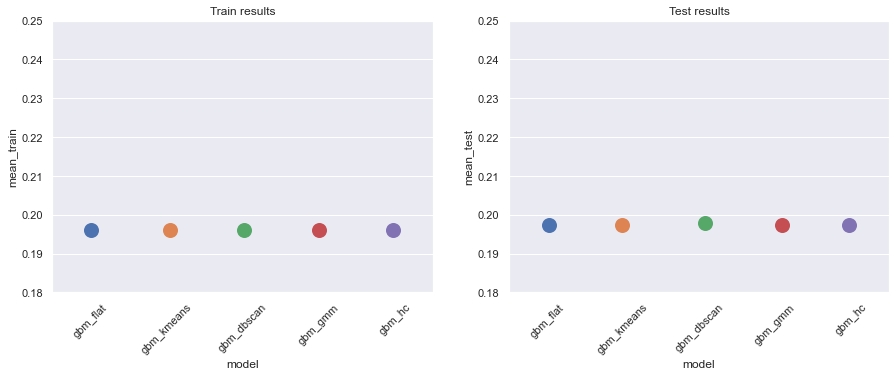

In [130]:
# Plot results for a graphical comparison
print("Spot Check Algorithms")
sns.set( rc = {'figure.figsize': (15, 5)})
plt.figure()
plt.subplot(1,2,1)  
sns.stripplot(x="model", y="mean_train",data=score,size=15)
plt.xticks(rotation=45)
plt.title('Train results')
axes = plt.gca()
axes.set_ylim([0.18,0.25])
plt.subplot(1,2,2)
sns.stripplot(x="model", y="mean_test",data=score,size=15)
plt.xticks(rotation=45)
plt.title('Test results')
axes = plt.gca()
axes.set_ylim([0.18,0.25])
plt.show()

Spot Check Algorithms


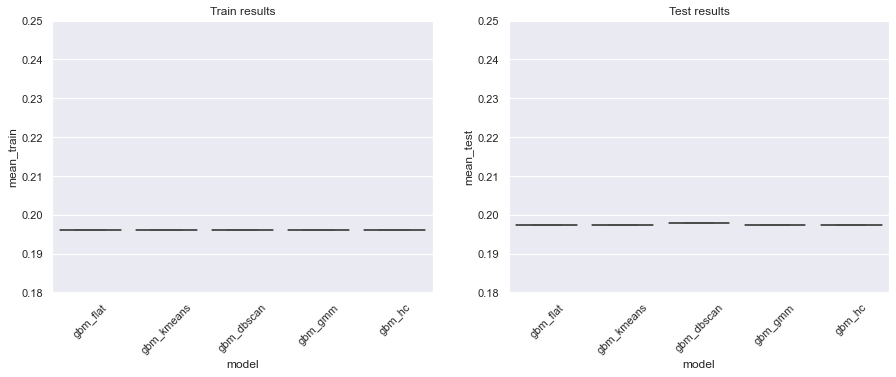

In [131]:
# Plot results for a graphical comparison
print("Spot Check Algorithms")
sns.set( rc = {'figure.figsize': (15, 5)})
plt.figure()
plt.subplot(1,2,1)  
sns.boxplot(x="model", y="mean_train",data=score)
plt.xticks(rotation=45)
plt.title('Train results')
axes = plt.gca()
axes.set_ylim([0.18,0.25])
plt.subplot(1,2,2)
sns.boxplot(x="model", y="mean_test",data=score)
plt.xticks(rotation=45)
plt.title('Test results')
axes = plt.gca()
axes.set_ylim([0.18,0.25])
plt.show()

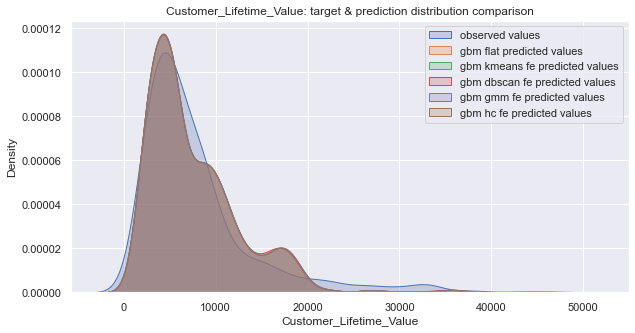

In [132]:
# Plot results
sns.set( rc = {'figure.figsize': (10, 5)})
fig,ax = plt.subplots(1, 1)
sns.kdeplot(x=test_df['Customer_Lifetime_Value'], fill=True, palette="crest", label="observed values")
sns.kdeplot(x=test_df['Customer_Lifetime_Value_predict_flat'], fill=True, palette="crest", label='gbm flat predicted values')
sns.kdeplot(x=test_df['Customer_Lifetime_Value_predict_kmeans'], fill=True, palette="crest", label='gbm kmeans fe predicted values')
sns.kdeplot(x=test_df['Customer_Lifetime_Value_predict_dbscan'], fill=True, palette="crest", label='gbm dbscan fe predicted values')
sns.kdeplot(x=test_df['Customer_Lifetime_Value_predict_gmm'], fill=True, palette="crest", label='gbm gmm fe predicted values')
sns.kdeplot(x=test_df['Customer_Lifetime_Value_predict_hc'], fill=True, palette="crest", label='gbm hc fe predicted values')
plt.title('Customer_Lifetime_Value: target & prediction distribution comparison')
ax.legend()
plt.show()

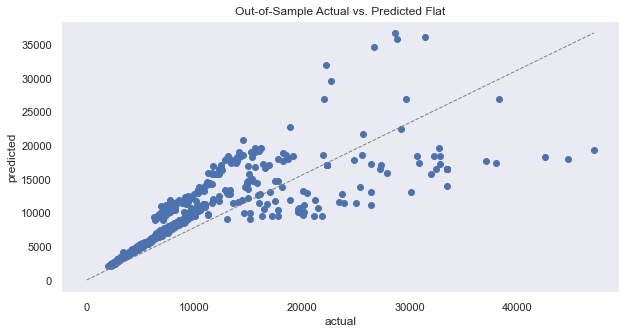

In [133]:
plt.scatter(test_df['Customer_Lifetime_Value'], test_df['Customer_Lifetime_Value_predict_flat'])
plt.plot([0, max(test_df['Customer_Lifetime_Value'])], [0, max(test_df['Customer_Lifetime_Value_predict_flat'])], color='gray', lw=1,
linestyle='--')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Out-of-Sample Actual vs. Predicted Flat')
plt.grid()
plt.show()

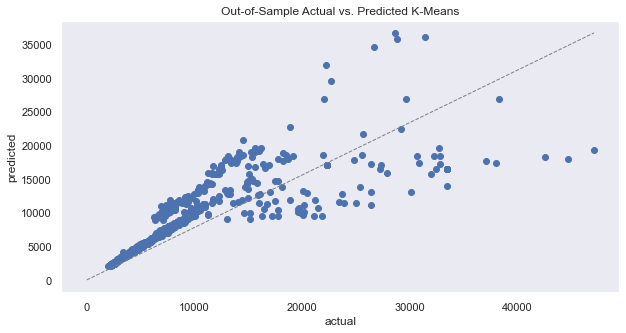

In [134]:
plt.scatter(test_df['Customer_Lifetime_Value'], test_df['Customer_Lifetime_Value_predict_kmeans'])
plt.plot([0, max(test_df['Customer_Lifetime_Value'])], [0, max(test_df['Customer_Lifetime_Value_predict_kmeans'])], color='gray', lw=1,
linestyle='--')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Out-of-Sample Actual vs. Predicted K-Means')
plt.grid()
plt.show()

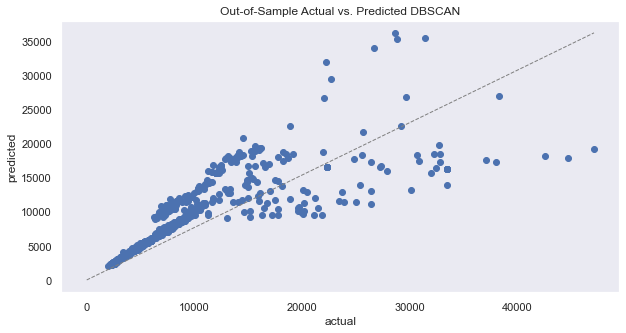

In [135]:
plt.scatter(test_df['Customer_Lifetime_Value'], test_df['Customer_Lifetime_Value_predict_dbscan'])
plt.plot([0, max(test_df['Customer_Lifetime_Value'])], [0, max(test_df['Customer_Lifetime_Value_predict_dbscan'])], color='gray', lw=1,
linestyle='--')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Out-of-Sample Actual vs. Predicted DBSCAN')
plt.grid()
plt.show()

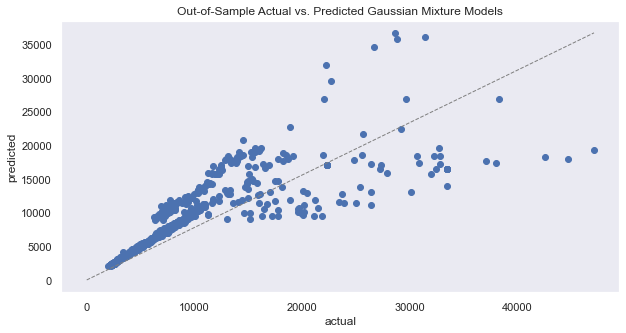

In [136]:
plt.scatter(test_df['Customer_Lifetime_Value'], test_df['Customer_Lifetime_Value_predict_gmm'])
plt.plot([0, max(test_df['Customer_Lifetime_Value'])], [0, max(test_df['Customer_Lifetime_Value_predict_gmm'])], color='gray', lw=1,
linestyle='--')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Out-of-Sample Actual vs. Predicted Gaussian Mixture Models')
plt.grid()
plt.show()

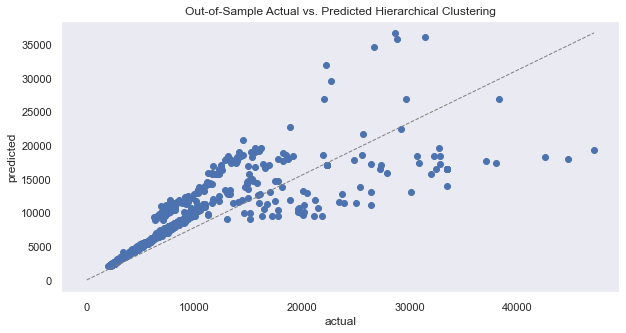

In [137]:
plt.scatter(test_df['Customer_Lifetime_Value'], test_df['Customer_Lifetime_Value_predict_hc'])
plt.plot([0, max(test_df['Customer_Lifetime_Value'])], [0, max(test_df['Customer_Lifetime_Value_predict_hc'])], color='gray', lw=1,
linestyle='--')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Out-of-Sample Actual vs. Predicted Hierarchical Clustering')
plt.grid()
plt.show()

In [138]:
test_df = pd.concat([test_df, test_kmeans['kmeans_cluster'], test_gmm['gmm_cluster'], test_dbscan['dbscan_cluster'], test_hc['hierarch_cluster']], axis=1)

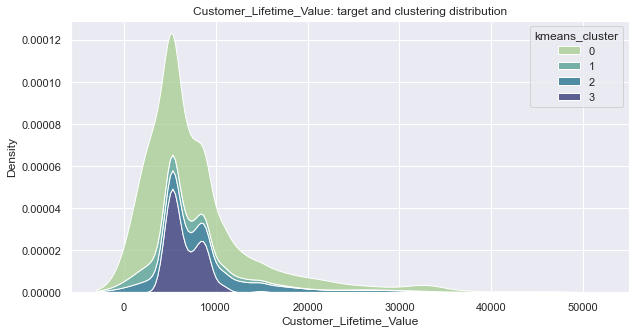

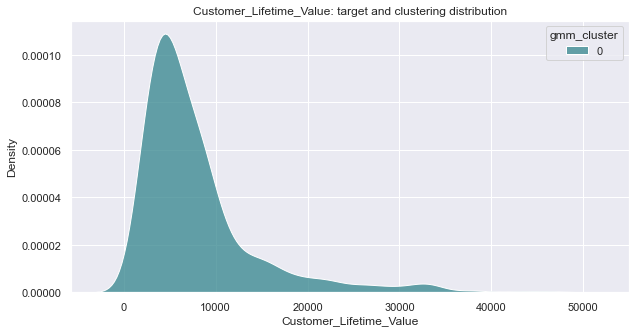

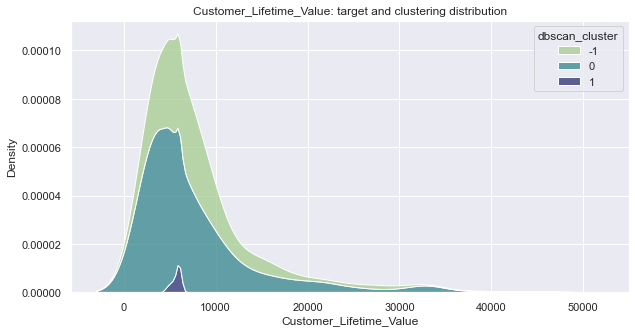

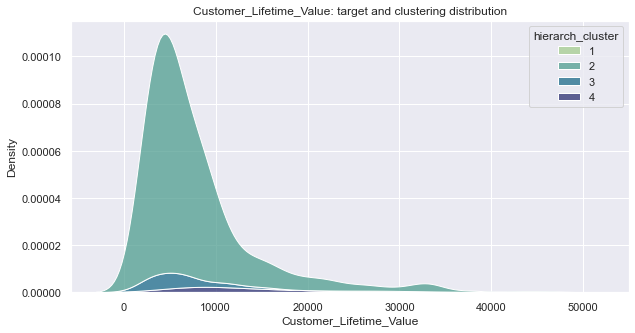

In [139]:
# Plot results
sns.set( rc = {'figure.figsize': (10, 5)})
sns.kdeplot(x=test_df['Customer_Lifetime_Value'], hue=test_df['kmeans_cluster'], palette="crest", multiple="stack")
plt.title('Customer_Lifetime_Value: target and clustering distribution')
plt.show()
sns.kdeplot(x=test_df['Customer_Lifetime_Value'], hue=test_df['gmm_cluster'], palette="crest", multiple="stack")
plt.title('Customer_Lifetime_Value: target and clustering distribution')
plt.show()
sns.kdeplot(x=test_df['Customer_Lifetime_Value'], hue=test_df['dbscan_cluster'], palette="crest", multiple="stack")
plt.title('Customer_Lifetime_Value: target and clustering distribution')
plt.show()
sns.kdeplot(x=test_df['Customer_Lifetime_Value'], hue=test_df['hierarch_cluster'], palette="crest", multiple="stack")
plt.title('Customer_Lifetime_Value: target and clustering distribution')
plt.show()

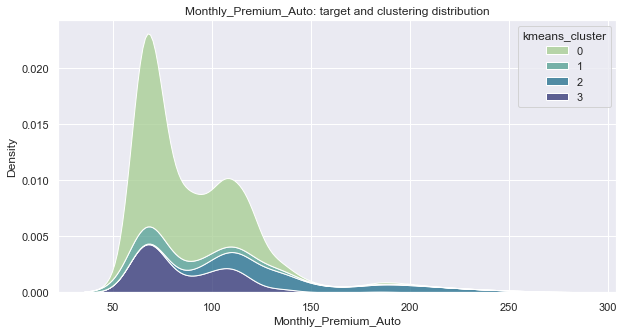

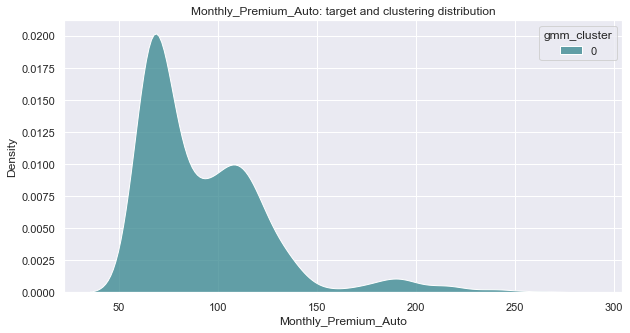

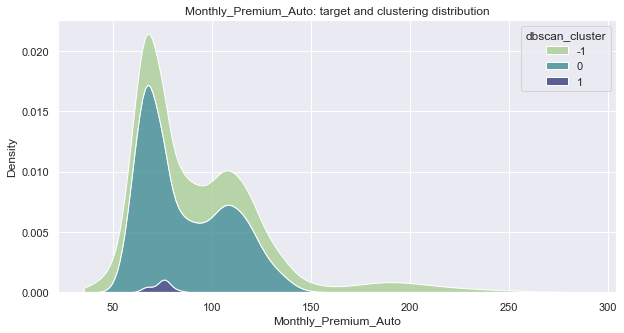

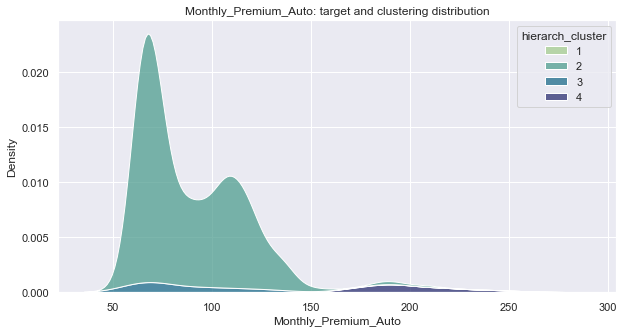

In [140]:
# Plot results
sns.set( rc = {'figure.figsize': (10, 5)})
sns.kdeplot(x=test_df['Monthly_Premium_Auto'], hue=test_df['kmeans_cluster'], palette="crest", multiple="stack")
plt.title('Monthly_Premium_Auto: target and clustering distribution')
plt.show()
sns.kdeplot(x=test_df['Monthly_Premium_Auto'], hue=test_df['gmm_cluster'], palette="crest", multiple="stack")
plt.title('Monthly_Premium_Auto: target and clustering distribution')
plt.show()
sns.kdeplot(x=test_df['Monthly_Premium_Auto'], hue=test_df['dbscan_cluster'], palette="crest", multiple="stack")
plt.title('Monthly_Premium_Auto: target and clustering distribution')
plt.show()
sns.kdeplot(x=test_df['Monthly_Premium_Auto'], hue=test_df['hierarch_cluster'], palette="crest", multiple="stack")
plt.title('Monthly_Premium_Auto: target and clustering distribution')
plt.show()

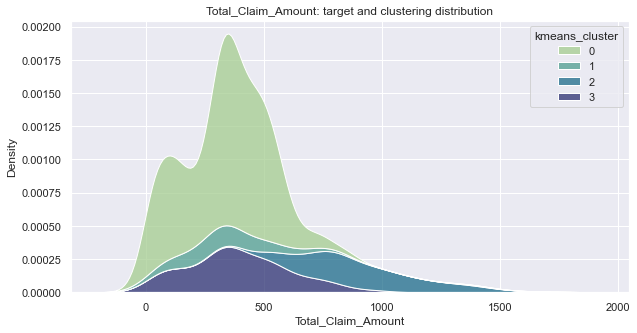

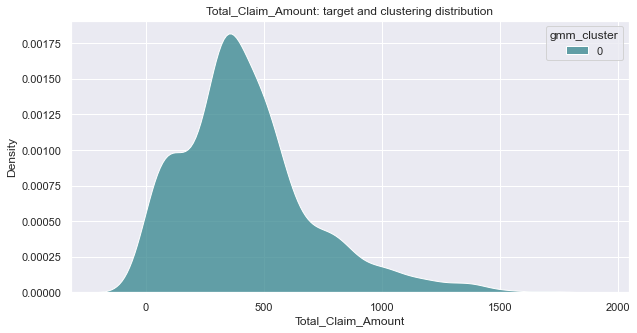

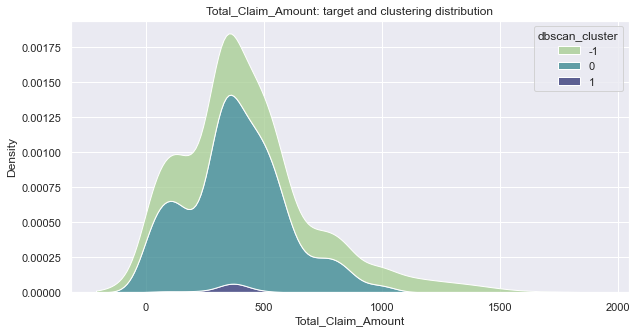

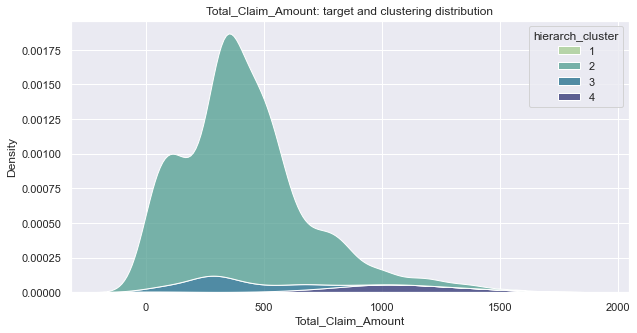

In [141]:
# Plot results
sns.set( rc = {'figure.figsize': (10, 5)})
sns.kdeplot(x=test_df['Total_Claim_Amount'], hue=test_df['kmeans_cluster'], palette="crest", multiple="stack")
plt.title('Total_Claim_Amount: target and clustering distribution')
plt.show()
sns.kdeplot(x=test_df['Total_Claim_Amount'], hue=test_df['gmm_cluster'], palette="crest", multiple="stack")
plt.title('Total_Claim_Amount: target and clustering distribution')
plt.show()
sns.kdeplot(x=test_df['Total_Claim_Amount'], hue=test_df['dbscan_cluster'], palette="crest", multiple="stack")
plt.title('Total_Claim_Amount: target and clustering distribution')
plt.show()
sns.kdeplot(x=test_df['Total_Claim_Amount'], hue=test_df['hierarch_cluster'], palette="crest", multiple="stack")
plt.title('Total_Claim_Amount: target and clustering distribution')
plt.show()

